In [ ]:
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from static import QuadcopterForceMoments
from uvlm import UVLM
from wind import WindField
from scipy.interpolate import UnivariateSpline
from scipy.io import savemat
from mpl_toolkits.mplot3d import Axes3D
from propeller import PropellerGeometry
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numba as nb
import copy
import pyvista as pv
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def visualize_wake_development(quad_propeller_mesh, wake_system, propeller_key="Propeller_1", 
                            show_bound=True, time_step=0, save_plot=False):
    """
    Visualize wake development at a specific time step with different colors for wake age.
    
    Args:
        quad_propeller_mesh: The mesh system
        wake_system: The wake system
        propeller_key: Which propeller to plot
        show_bound: Whether to show bound vortex system
        time_step: Current time step for labeling
        save_plot: Whether to save the plot to file
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Color map for wake age
    wake_colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 different colors for wake age
    
    # Plot bound system if requested
    if show_bound:
        propeller_data = quad_propeller_mesh[propeller_key]
        for blade_key, blade_data in propeller_data['Blades'].items():
            # Plot bound vortex rings
            for panel_index, vortex_ring in blade_data['Vortex Rings'].items():
                vertices = np.array(vortex_ring['Vertices'])
                
                # Plot bound vertices
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
                        color='blue', alpha=0.5, s=50)
                
                # Connect bound vertices
                for i in range(4):
                    start = vertices[i]
                    end = vertices[(i + 1) % 4]
                    ax.plot([start[0], end[0]], 
                        [start[1], end[1]], 
                        [start[2], end[2]], 
                        'b-', alpha=0.5)
    
    # Plot wake system with color-coded age
    wake_data = wake_system[propeller_key]
    for blade_key, blade_data in wake_data.items():
        for wake_index, wake_panel in blade_data.items():
            if 'Vortex Rings' in wake_panel and wake_panel['Vortex Rings']['Vertices'] is not None:
                vertices = np.array(wake_panel['Vortex Rings']['Vertices'])
                
                # Determine wake age and corresponding color
                wake_age = wake_index[0]  # Using first index as age indicator
                color_index = min(wake_age, len(wake_colors)-1)
                wake_color = wake_colors[color_index]
                
                # Plot wake vertices
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
                        color=wake_color, alpha=0.7, s=30)
                
                # Connect wake vertices with age-colored lines
                for i in range(4):
                    start = vertices[i]
                    end = vertices[(i + 1) % 4]
                    ax.plot([start[0], end[0]], 
                        [start[1], end[1]], 
                        [start[2], end[2]], 
                        color=wake_color, alpha=0.7)
                
                # Plot wake control points if they exist
                if wake_panel['Control Points'] is not None:
                    cp = wake_panel['Control Points']
                    ax.scatter(cp[0], cp[1], cp[2], color='red', s=50)
    
    # Add legend and labels
    ax.scatter([], [], [], c='blue', alpha=0.5, s=50, label='Bound Vertices')
    ax.scatter([], [], [], c='red', s=50, label='Wake Control Points')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Wake Development - {propeller_key} (Time Step: {time_step})')
    
    # Add colorbar to show wake age
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Wake Age')
    
    # Set equal aspect ratio
    max_range = np.array([
        ax.get_xlim3d()[1] - ax.get_xlim3d()[0],
        ax.get_ylim3d()[1] - ax.get_ylim3d()[0],
        ax.get_zlim3d()[1] - ax.get_zlim3d()[0]
    ]).max() / 2.0
    
    mid_x = (ax.get_xlim3d()[1] + ax.get_xlim3d()[0]) / 2.0
    mid_y = (ax.get_ylim3d()[1] + ax.get_ylim3d()[0]) / 2.0
    mid_z = (ax.get_zlim3d()[1] + ax.get_zlim3d()[0]) / 2.0
    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])
    
    # Save plot if requested
    if save_plot:
        plt.savefig(f'wake_development_step_{time_step}.png')
    
    plt.show()

def store_wake_state(propeller_mesh, wake_system):
    """Store current state of wake system"""
    state = {
        'bound_vertices': [],
        'wake_vertices': [],
        'control_points': []
    }

    # Store bound vortex rings
    for prop_key, prop_data in propeller_mesh.items():
        for blade_key, blade_data in prop_data['Blades'].items():
            for vortex_ring in blade_data['Vortex Rings'].values():
                state['bound_vertices'].append(np.array(vortex_ring['Vertices']))

    # Store wake panels
    for prop_key, prop_data in wake_system.items():
        for blade_key, blade_data in prop_data.items():
            for wake_panel in blade_data.values():
                if wake_panel['Vortex Rings']['Vertices'] is not None:
                    state['wake_vertices'].append(np.array(wake_panel['Vortex Rings']['Vertices']))
                if wake_panel['Control Points'] is not None:
                    state['control_points'].append(np.array(wake_panel['Control Points']))

    return state

def store_wake_state(propeller_mesh, wake_system):
    """Store current state of wake system"""
    state = {
        'bound_vertices': [],
        'wake_vertices': [],
        'control_points': []
    }

    # Debug prints
    print("\nStoring wake state:")
    print("Number of propellers:", len(propeller_mesh))

    # Store bound vortex rings
    for prop_key, prop_data in propeller_mesh.items():
        print(f"\nProcessing {prop_key}")
        for blade_key, blade_data in prop_data['Blades'].items():
            print(f"Processing {blade_key}, number of vortex rings:", len(blade_data['Vortex Rings']))
            for vr_idx, vortex_ring in blade_data['Vortex Rings'].items():
                vertices = np.array(vortex_ring['Vertices'])
                print(f"Vortex ring {vr_idx} vertices shape:", vertices.shape)
                state['bound_vertices'].append(vertices)

    # Store wake panels
    print("\nProcessing wake system:")
    for prop_key, prop_data in wake_system.items():
        print(f"\nPropeller {prop_key} wake:")
        for blade_key, blade_data in prop_data.items():
            print(f"Blade {blade_key} wake panels:", len(blade_data))
            for wake_idx, wake_panel in blade_data.items():
                if wake_panel['Vortex Rings']['Vertices'] is not None:
                    vertices = np.array(wake_panel['Vortex Rings']['Vertices'])
                    print(f"Wake panel {wake_idx} vertices shape:", vertices.shape)
                    state['wake_vertices'].append(vertices)
                if wake_panel['Control Points'] is not None:
                    cp = np.array(wake_panel['Control Points'])
                    print(f"Control point {wake_idx} shape:", cp.shape)
                    state['control_points'].append(cp)

    print("\nFinal state sizes:")
    print("Bound vertices:", len(state['bound_vertices']))
    print("Wake vertices:", len(state['wake_vertices']))
    print("Control points:", len(state['control_points']))

    return state


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------_#
# Usage in your main simulation:
wake_states = []  # List to store states at each time step

# Initialize geometry and mesh
propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='DJI9443_airfoils.csv',
    chorddist_file='DJI9443_chorddist.csv',
    pitchdist_file='DJI9443_pitchdist.csv',
    sweepdist_file='DJI9443_sweepdist.csv',
    heightdist_file='DJI9443_heightdist.csv',
    R_tip=0.12,
    num_blades=3,  # Creates a tri-blade propeller
    R_hub=0.0064
)

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=0.175, com=(0, 0, 0))

quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()

# Initialize SixDOF dynamics
mass = 0.68  # kg

inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]

])  # Simple diagonal inertia matrix for example

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates

omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, 565.9]),
    'Propeller_2': np.array([0, 0, -565.9]),
    'Propeller_3': np.array([0, 0, -565.9]),
    'Propeller_4': np.array([0, 0, 565.9])
}


# Initialize the UVLM solver
uvlm_solver = UVLM(quad_propeller_mesh)
wake_states = []



dynamics = SixDOFDynamics(
    mass=mass,
    inertia_matrix=inertia_matrix,
    initial_position=np.zeros(3),
    initial_velocity_body=np.zeros(3),
    initial_angles=np.zeros(3),
    initial_angular_rates=np.zeros(3)
)

total_time = 5 
dt = 5  #
time_steps = int(total_time / dt)


wake_history = []
time_points = []
normalized_forces = []
rho = 1.071778   
rpm = 90
force_moment_calc = QuadcopterForceMoments(
    arm_length=0.5, 
    com_position=[0, 0, 0]  
)

mesh = pv.read(r"C:\Users\KU5001153\Downloads\bp_50percent_147.vtk") 
wind_field = WindField(mesh)

com_position = np.array([300, 120, 50])
time_steps = 2
omega = 565.486677  # rad/s
n_steps = 2        # number of steps per revolution
angles = np.linspace(0, np.pi, n_steps, endpoint=False)  # Changed to 2*np.pi for full revolution
dt = (2*np.pi) / (omega * n_steps)
time_step = 2

thrust_data = []


# Calculate forces
forces_and_moments = uvlm_solver.calculate_total_forces_and_moments(
    propeller_mesh=quad_propeller_mesh,
    dt=dt,
    rho=rho,
    time_step=time_step,
    body_velocity=dynamics.velocity_body,
    omega=omega_dict,
    wind_field=wind_field,
    com_position=com_position,
    roll=dynamics.angles[0],
    pitch=dynamics.angles[1],
    yaw=dynamics.angles[2]
)

blade_1 = quad_propeller_mesh['Propeller_1']['Blades']['Blade_1']
blade_2 = quad_propeller_mesh['Propeller_1']['Blades']['Blade_2']
thrust_data.append(uvlm_solver.collect_thrust_data(blade_1, blade_2, angle))




In [ ]:
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from static import QuadcopterForceMoments
from uvlm import UVLM
from wind import WindField
from scipy.interpolate import UnivariateSpline
from scipy.io import savemat
from mpl_toolkits.mplot3d import Axes3D
from propeller import PropellerGeometry
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numba as nb
import copy
import pyvista as pv
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------_#

# Initialize geometry and mesh
propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='DJI9443_airfoils.csv',
    chorddist_file='DJI9443_chorddist.csv',
    pitchdist_file='DJI9443_pitchdist.csv',
    sweepdist_file='DJI9443_sweepdist.csv',
    heightdist_file='DJI9443_heightdist.csv',
    R_tip=0.12,
    R_hub=0.0064,
    num_blades=3,  # Creates a tri-blade propeller
)

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=0.175, com=(0, 0, 0))

quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()

# Initialize SixDOF dynamics
mass = 0.68  # kg

inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]

])  # Simple diagonal inertia matrix for example

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates

omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, 565.9]),
    'Propeller_2': np.array([0, 0, -565.9]),
    'Propeller_3': np.array([0, 0, -565.9]),
    'Propeller_4': np.array([0, 0, 565.9])
}

propeller_mesh_system.plot_propeller_mesh_with_highlight(
    quad_propeller_mesh,
    propeller_key='Propeller_1',
    blade_key='Blade_3',
    highlight_panel=(3,0)
)


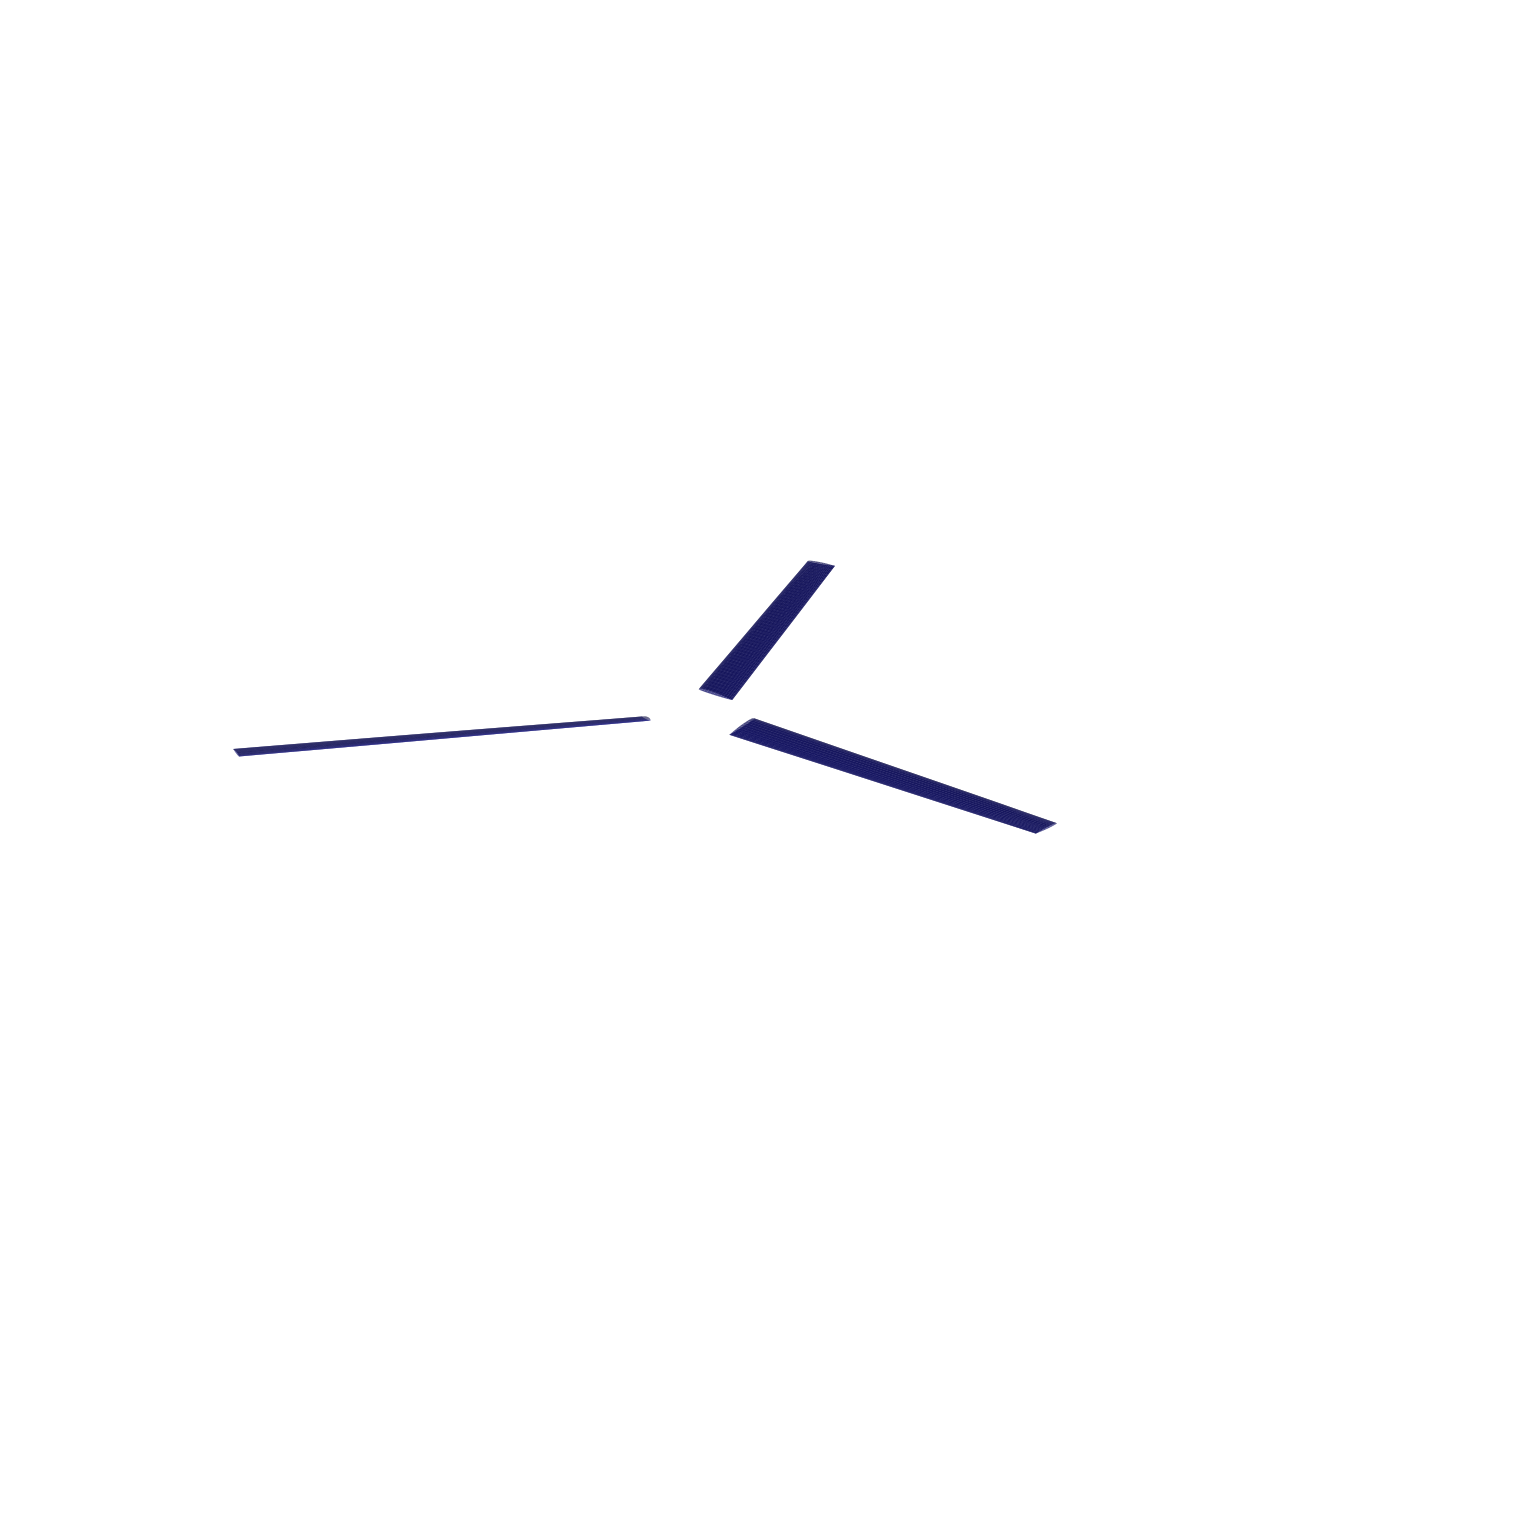

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.io import savemat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from propeller import PropellerGeometry
from mesh import PropellerMesh
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec

# Initialize and generate mesh as before
propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='NASA_UAM_quadrotor.csv',
    chorddist_file='NASA_UAM_quadrotor_chorddist.csv',
    pitchdist_file='NASA_UAM_quadrotor_pitchdist.csv',
    sweepdist_file='NASA_UAM_quadrotor_sweepdist.csv',
    R_tip=2.809,
    R_hub=0.3372,
    num_blades=3
)

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=1.5, com=(0, 0, 0))
quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()

def plot_clean_blade_quadrotor(propeller_geometry, propeller_mesh_system):
    """
    Plot all four propellers with clean visualization (no grid, title, labels, or ticks).
    """
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get hub positions
    hub_positions = propeller_mesh_system._generate_hub_points()
    
    # Generate base blade geometry
    X, Y, Z, X2, Y2, Z2 = propeller_geometry.generate_blade_geometry()
    
    # Colors for different propellers
    propeller_colors = ['navy', 'darkred', 'darkgreen', 'purple']
    propeller_colors = ['navy', 'navy', 'navy', 'navy']

    
    # Plot each propeller
    for idx, hub_pos in enumerate(hub_positions):
        # For each blade in the propeller
        for blade_idx in range(propeller_geometry.num_blades):
            # Rotate blade based on blade index
            blade_angle = blade_idx * (2 * np.pi / propeller_geometry.num_blades)
            rotation_matrix = np.array([
                [np.cos(blade_angle), -np.sin(blade_angle), 0],
                [np.sin(blade_angle), np.cos(blade_angle), 0],
                [0, 0, 1]
            ])
            
            # Transform the blade surface
            if idx in [0, 3]:  # Propellers 1 and 4 (CW)
                X_transformed = X
                Y_transformed = Y
                Z_transformed = Z
            else:  # Propellers 2 and 3 (CCW)
                X_transformed = -X
                Y_transformed = Y
                Z_transformed = Z
            
            # Rotate blade around hub
            points = np.array([X_transformed.flatten(), Y_transformed.flatten(), Z_transformed.flatten()])
            rotated_points = np.dot(rotation_matrix, points)
            X_rotated = rotated_points[0].reshape(X.shape) + hub_pos[0]
            Y_rotated = rotated_points[1].reshape(Y.shape) + hub_pos[1]
            Z_rotated = rotated_points[2].reshape(Z.shape) + hub_pos[2]
            
            # Plot the surface
            surf = ax.plot_surface(X_rotated, Y_rotated, Z_rotated, 
                                 color=propeller_colors[idx], alpha=0.7,
                                 shade=True, antialiased=True)
    
    # # Add text labels to the right of each propeller
    # for idx, hub_pos in enumerate(hub_positions):
    #     # Position all text labels to the right of each hub
    #     text_pos = [hub_pos[0] + 1.2, hub_pos[1] - 0.7, hub_pos[2] - 0.8]
            
    #     # Add text without bounding box
    #     ax.text(text_pos[0], text_pos[1], text_pos[2], 
    #             f"Propeller {idx+1}", 
    #             color='black', 
    #             fontsize=20, 
    #             ha='left', 
    #             va='center')
    
    # Remove title and labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_title('')
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Remove grid
    ax.grid(False)
    
    # Remove panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    
    # Completely hide axis lines
    ax.set_axis_off()
    
    # Set equal aspect ratio
    max_range = np.array([
        ax.get_xlim3d()[1] - ax.get_xlim3d()[0],
        ax.get_ylim3d()[1] - ax.get_ylim3d()[0],
        ax.get_zlim3d()[1] - ax.get_zlim3d()[0]
    ]).max() / 2.0
    
    mid_x = (ax.get_xlim3d()[1] + ax.get_xlim3d()[0]) / 2.0
    mid_y = (ax.get_ylim3d()[1] + ax.get_ylim3d()[0]) / 2.0
    mid_z = (ax.get_zlim3d()[1] + ax.get_zlim3d()[0]) / 2.0
    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])
    
    # Set viewing angle for better visualization
    ax.view_init(elev=20, azim=45)
    
    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Reduce figure white space and margins
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.tight_layout(pad=0)
    plt.savefig('clean_quadrotor_plot.png', transparent=False, bbox_inches='tight', pad_inches=0)
    plt.show()

# Usage:
plot_clean_blade_quadrotor(propeller_geometry, propeller_mesh_system)